In [1]:
from __future__ import print_function
import time
import numpy as np
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: GeForce GTX 670 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5005)
/home/krautcat/cuda/ml-4/cifar-10/theano-env/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
import pickle

import matplotlib.pyplot as plt

In [3]:
import sys
import os
import time
import glob

### Загружаем предобработанную базу изображений

In [4]:
dirpath='cifar-100-python'
# load training data
X, y = [], []

path = '%s/train' % dirpath
with open(path, 'rb') as f:
    batch = pickle.load(f)

X.append(batch['data'])
y.append(batch['coarse_labels'])

X = np.concatenate(X) \
      .reshape(-1, 3, 32, 32) \
      .astype(np.float32)
y = np.concatenate(y).astype(np.int32)

# split into training and validation sets
ii = np.random.permutation(len(X))
X_train = X[ii[100:]]
y_train = y[ii[100:]]
X_valid = X[ii[:100]]
y_valid = y[ii[:100]]

# load test set
path = '%s/test' % dirpath
with open(path, 'rb') as f:
    batch = pickle.load(f)

X_test = batch['data'] \
         .reshape(-1, 3, 32, 32) \
         .astype(np.float32)
y_test = np.array(batch['coarse_labels'], dtype=np.int32)

# normalize to zero mean and unity variance
offset = np.mean(X_train, 0)
scale = np.std(X_train, 0).clip(min=1)

X_train = (X_train - offset) / scale
X_valid = (X_valid - offset) / scale
X_test = (X_test - offset) / scale

In [6]:
def build_cnn(input_var=None,
              crp_num_filters=64, crp_filter_size=3,):
    
    network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
            network, 
            num_filters = 3 * crp_num_filters, 
            filter_size = (crp_filter_size, crp_filter_size),
            nonlinearity = lasagne.nonlinearities.rectify,
            W = lasagne.init.GlorotUniform())

    network = lasagne.layers.Conv2DLayer(
            network, 
            num_filters = 2 * crp_num_filters,
            filter_size = (crp_filter_size, crp_filter_size),
            nonlinearity = lasagne.nonlinearities.rectify,
            W = lasagne.init.GlorotUniform(gain='relu'))
    
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    network = lasagne.layers.Conv2DLayer(
            network, 
            num_filters = crp_num_filters,
            filter_size = (crp_filter_size, crp_filter_size),
            nonlinearity = lasagne.nonlinearities.rectify,
            W = lasagne.init.GlorotUniform(gain='relu'))
    
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units = 128,
            nonlinearity = lasagne.nonlinearities.rectify)

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units = 20,
            nonlinearity = lasagne.nonlinearities.softmax)

    return network

In [7]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [8]:
input_var = T.tensor4('inputs')
target_var = T.ivector('target')

In [9]:
network = build_cnn(input_var)

In [10]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

/home/krautcat/cuda/ml-4/cifar-10/theano-env/local/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [11]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                        dtype=theano.config.floatX)

In [12]:
pred = test_prediction.argmax(-1)
f_predict = theano.function([input_var], pred)

In [13]:
train_fn = theano.function([input_var, target_var], 
                           loss, 
                           updates=updates,
                           allow_input_downcast=True)

val_fn = theano.function([input_var, target_var], 
                         [test_loss, test_acc],
                         allow_input_downcast=True)

### Обучаем модель

In [14]:
BATCH_SIZE = 28

In [15]:
num_epochs = 20

Параметры лучшей модели

In [16]:
best_val_acc = 0.0
best_model = None

In [17]:
loss_history = []
val_acc_history = []

In [24]:
for epoch in range(num_epochs):
    
    train_err = 0
    train_batches = 0
    
    start_time = time.time()
    
    for batch in iterate_minibatches(X_train, y_train, BATCH_SIZE, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1
    
    # validation accuracy
    val_err = 0
    val_acc = 0
    val_batches = 0
    
    for batch in iterate_minibatches(X_valid, y_valid, BATCH_SIZE, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
    val_acc /= val_batches
    val_acc_history.append(val_acc)
    
    # keep track of the best model based on validation accuracy
    if val_acc > best_val_acc:
        # make a copy of the model
        best_val_acc = val_acc
        best_model = lasagne.layers.get_all_param_values(network)
        
    print("Epoch: {}, train: {}, val: {}, accuracy: {}, time: {} sec".format(epoch, 
                                                train_err/train_batches,
                                                val_err/val_batches,
                                                val_acc,
                                                time.time() - start_time))

Epoch: 0, train: 1.82089155337, val: 1.71274546782, accuracy: 0.452380945285, time: 89.2219970226 sec
Epoch: 1, train: 1.8240412469, val: 1.7417747577, accuracy: 0.369047621886, time: 90.8842329979 sec
Epoch: 2, train: 1.81665892623, val: 1.69432926178, accuracy: 0.488095243772, time: 90.8538339138 sec
Epoch: 3, train: 1.81647131479, val: 1.74427727858, accuracy: 0.416666666667, time: 89.8996758461 sec
Epoch: 4, train: 1.81588569916, val: 1.58280193806, accuracy: 0.523809512456, time: 90.1870889664 sec
Epoch: 5, train: 1.80741173574, val: 1.62536044916, accuracy: 0.488095223904, time: 91.2918448448 sec
Epoch: 6, train: 1.80369377196, val: 1.71048847834, accuracy: 0.464285711447, time: 91.9386129379 sec
Epoch: 7, train: 1.7961186093, val: 1.61113289992, accuracy: 0.464285711447, time: 92.1221761703 sec
Epoch: 8, train: 1.7982619548, val: 1.68588554859, accuracy: 0.464285711447, time: 91.4795680046 sec
Epoch: 9, train: 1.79395337675, val: 1.60425841808, accuracy: 0.488095243772, time: 90

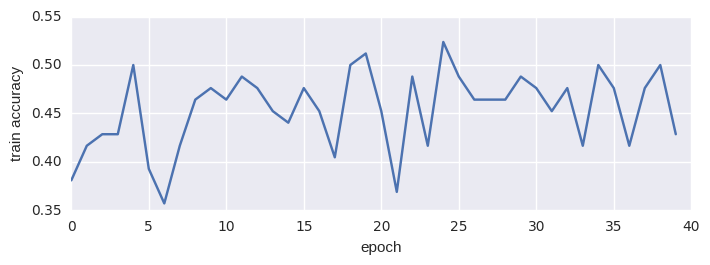

In [25]:
# plt.subplot(2, 1, 1)
# plt.plot(np.array(loss_history).clip(max=3))
# plt.xlabel('iteration')
# plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(val_acc_history)
# plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('train accuracy')
plt.show()

### Тест модели

In [26]:
y_true = []
y_pred = []

lasagne.layers.set_all_param_values(network, best_model)

for i in range(10000):
    y_true.append(int(y_test[i]))
    y_pred.append(f_predict([X_test[i]])[0])

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
CM = confusion_matrix(y_true, y_pred)

In [29]:
import seaborn as sns

fig = plt.figure(figsize=(20, 20))
sns.heatmap(CM, annot=True, fmt="d", linewidths=.5)
plt.show()